In [ ]:
!pip install tensorflow

In [ ]:
!pip install tensorflow-gpu

In [5]:
!pip install opencv-python matplotlib

In [ ]:
!pip list

In [6]:
# I have refered it from stackoverflow to check the version and trying to fix the above tensor flow GPU error
# https://stackoverflow.com/questions/76453565/error-installing-tensorflow-gpu-in-google-colab-subprocess-exited-with-error

import tensorflow as tf
tf.__version__

'2.15.0'

In [ ]:
!python --version

In [ ]:
tf.config.list_physical_devices()

In [7]:
# Using to navigate through file Structures
import os

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
# When we download images from Internet, that might no be open in python because of currupted, mislabeled, and mis-extension
# This particular block will help to get rid from that

import cv2
# Use to check the file extension for our images
import imghdr

from matplotlib import pyplot as plt

In [9]:
data_dir = 'sample_data/Data'

In [10]:
image_exts = ['jpeg','jpg', 'bmp', 'svg', 'png']

In [ ]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            # load images to opencv
            img = cv2.imread(image_path)
            # match the file extension
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

In [14]:
# Load Data

import numpy as np
from matplotlib import pyplot as plt

In [15]:
# This is useful to building out data pipeline
data = tf.keras.utils.image_dataset_from_directory(data_dir)


Found 240 files belonging to 3 classes.


In [16]:
# This going to help us to access the data
# This will help us to accessing the data pipeline
data_iterator = data.as_numpy_iterator()


In [18]:
#  accessing the data pipeline itself
batch = data_iterator.next()
# Represent the image as numpy array
batch[0].shape
# Represent the label of the class
# Class 0 = Angry
# Class 1 = Happy
# Class 2 = Sad
batch[1]

array([1, 1, 2, 0, 0, 0, 2, 0, 1, 0, 0, 1, 2, 1, 1, 2, 1, 1, 2, 0, 2, 1,
       0, 1, 0, 1, 2, 2, 2, 0, 0, 1], dtype=int32)

In [ ]:
batch[0].max()

255.0

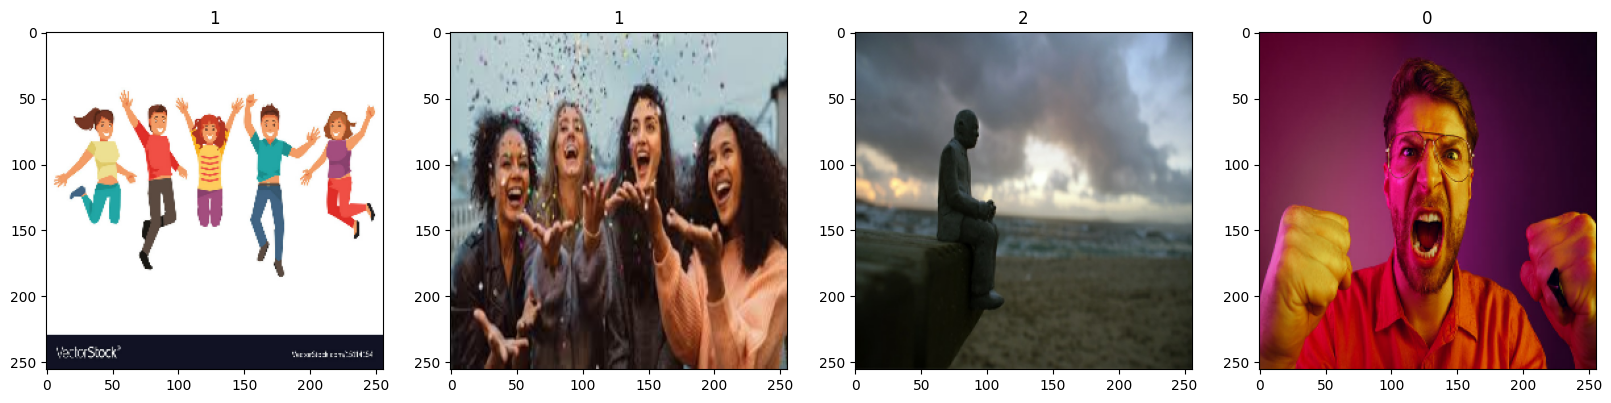

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

PreProcessing the Data

In [20]:
# Scaling data
data = data.map(lambda x,y: (x/255, y))

In [21]:
scaled_iterator = data.as_numpy_iterator()

In [22]:
batch = scaled_iterator.next()

In [24]:
batch[0].max()

1.0

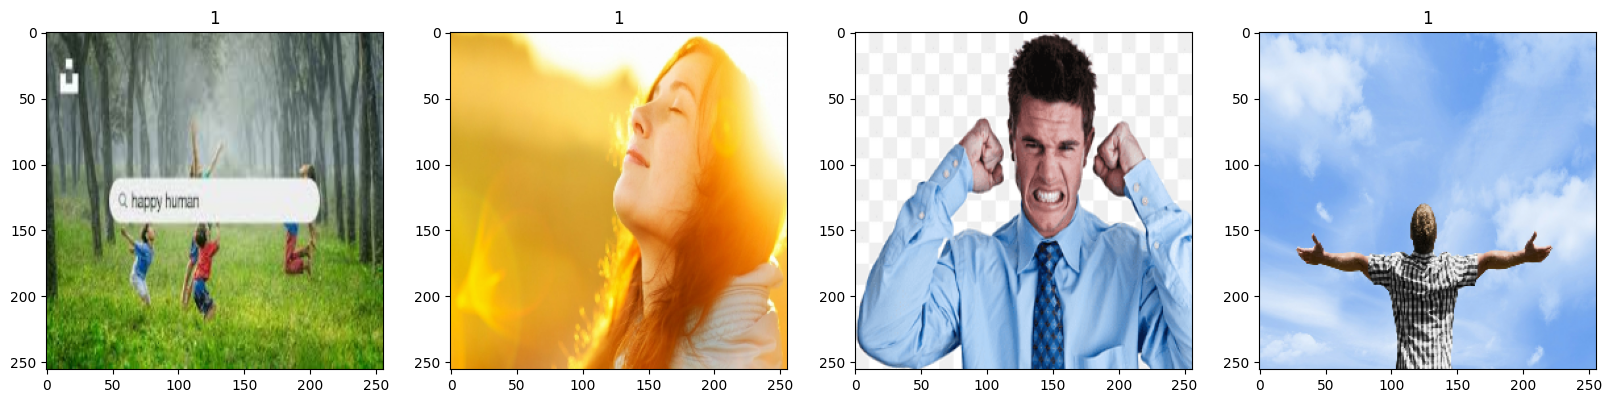

In [25]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

Spliting Data

In [26]:
len(data)

8

In [27]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [ ]:
train_size

5

In [28]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [31]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Deep Model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [34]:
model = Sequential()

In [35]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [52]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])


In [46]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [49]:
logdir = 'log'

In [50]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [53]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/10
5/5 [==============================] - 18s 3s/step - loss: -1118.0144 - accuracy: 0.4250 - val_loss: -2836.0762 - val_accuracy: 0.4375
Epoch 2/10
5/5 [==============================] - 15s 3s/step - loss: -1513.6227 - accuracy: 0.4000 - val_loss: 22.6908 - val_accuracy: 0.3281
Epoch 3/10
5/5 [==============================] - 16s 3s/step - loss: -1985.9922 - accuracy: 0.3688 - val_loss: -349.2222 - val_accuracy: 0.3594
Epoch 4/10
5/5 [==============================] - 17s 3s/step - loss: -2668.4128 - accuracy: 0.3875 - val_loss: -265.6334 - val_accuracy: 0.4531
Epoch 5/10
5/5 [==============================] - 16s 3s/step - loss: -3696.8530 - accuracy: 0.4125 - val_loss: -6671.0771 - val_accuracy: 0.5156
Epoch 6/10
5/5 [==============================] - 17s 3s/step - loss: -4443.3013 - accuracy: 0.4000 - val_loss: -7800.1270 - val_accuracy: 0.3438
Epoch 7/10
5/5 [==============================] - 16s 3s/step - loss: -6588.2861 - accuracy: 0.4000 - val_loss: -20454.1348 - val

Plot Performance

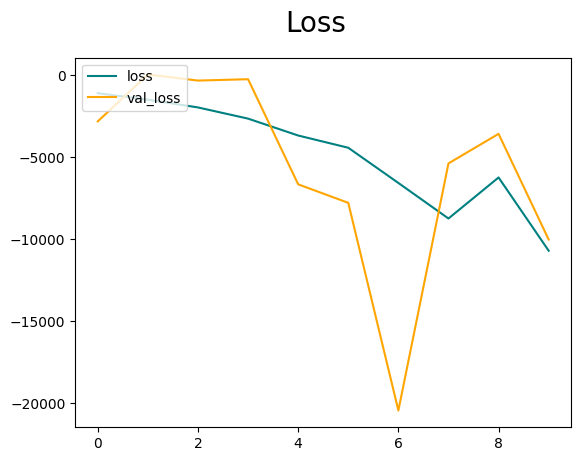

In [54]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

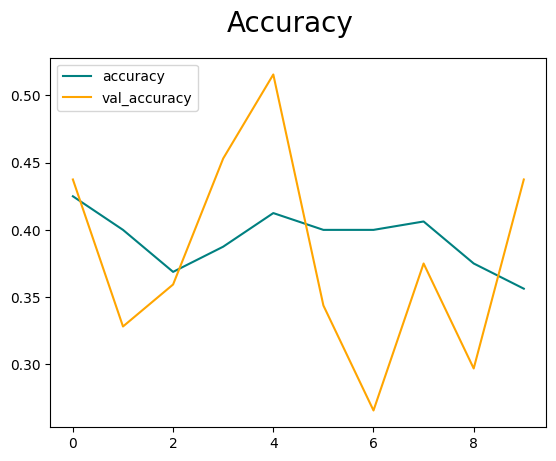

In [55]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Evaluate Performance

In [56]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy


In [57]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [58]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 305ms/step


In [59]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result()}, Accuracy:{acc.result()}')

Precision:0.7857142686843872, Recall:0.8461538553237915, Accuracy:0.375


Test

In [ ]:
import cv2


array([[[14, 13, 15],
        [14, 13, 15],
        [14, 14, 14],
        ...,
        [26, 17, 13],
        [26, 20, 15],
        [26, 20, 13]],

       [[15, 14, 16],
        [15, 14, 16],
        [15, 15, 15],
        ...,
        [27, 18, 14],
        [26, 20, 13],
        [26, 20, 13]],

       [[17, 16, 18],
        [17, 16, 18],
        [17, 17, 17],
        ...,
        [28, 19, 15],
        [29, 21, 14],
        [29, 22, 13]],

       ...,

       [[ 2,  2,  2],
        [ 2,  2,  2],
        [ 2,  2,  2],
        ...,
        [17, 22, 21],
        [ 1,  9,  8],
        [ 0, 10,  8]],

       [[ 2,  2,  2],
        [ 2,  2,  2],
        [ 2,  2,  2],
        ...,
        [24, 29, 28],
        [25, 30, 31],
        [23, 31, 31]],

       [[ 2,  2,  2],
        [ 2,  2,  2],
        [ 2,  2,  2],
        ...,
        [ 6, 11, 10],
        [ 2,  7,  8],
        [ 0,  8,  8]]], dtype=uint8)
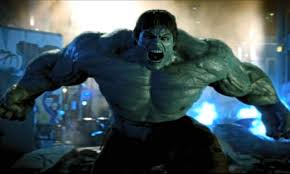

In [104]:
img = cv2.imread('sample_data/Data/Angry_Test.jpeg')
img

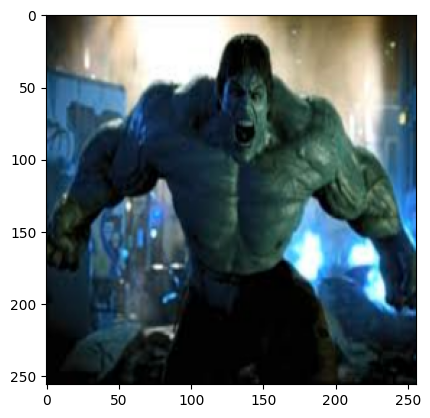

In [105]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

Our Neural Network expects to pass through the batch of images not a single image. So we need to encapsulate it inside of another set of parenthesis

In [101]:
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [106]:
yhat = model.predict(np.expand_dims(resize/255, 0))


1/1 [==============================] - 0s 43ms/step


In [107]:
yhat[0][0]

1.0

In [108]:
if yhat == 0 and yhat < 0.5:
    print(f'Predicted class is Happy')
elif yhat > 0.5 and yhat < 1.1:
    print(f'Predicted class is Happy')
elif yhat > 1.1 and yhat < 2:
    print(f'Predicted class is Sad')

Predicted class is Happy
